# Pymaceuticals Inc.
---

### Analysis
While the study was held for the purpose figuring out which drug regimen was  
the most successful in treating squamous cell carcinoma (SCC), it also shed a  
light on how mice in general react to anti-cancer drugs and solutions. Distributions  
within different groupings are largely similar enough to compare and of a big  
enough size to analyze in the first place.  

Finding the highest performing treatments signals a few things:  
    1. The lowest tumor size mean of a drug regimen  
    2. Smaller median value for tumor size by drug  
    3. Lower standard deviation in tumor size  
    4. Final tumor sizes are the smallest  

The boxplot could be easily expanded to include all drug regimens, but based off  
the evidence accumulated from the summaries and using the following code a cleaner  
picture is painted as to how well the drugs perform.  
```
INPUT:

mean = clean_df_summary.sort_values('Mean Tumor Volume').iloc[:5, 0].index
median = clean_df_summary.sort_values('Median Tumor Volume').iloc[:5, 1].index
variance = clean_df_summary.sort_values('Tumor Volume Variance').iloc[:5, 2].index
std_dev = clean_df_summary.sort_values('Tumor Volume Std. Dev.').iloc[:5, 3].index
std_err = clean_df_summary.sort_values('Tumor Volume Std. Err.').iloc[:5, 4].index
rank = 1
print('          Mean     Median    Variance    Std Dev   Std Err')
print('-'*65)
for a,b,c,d,e in zip(mean, median, variance, std_dev, std_err):
    print(f'Rank {rank}: {a}, {b}, {c}, {d}, {e}')
    rank += 1
```
```
OUTPUT:

          Mean     Median    Variance    Std Dev    Std Err
-----------------------------------------------------------------
Rank 1: Ramicane, Ramicane, Ramicane, Ramicane, Ramicane
Rank 2: Capomulin, Capomulin, Capomulin, Capomulin, Capomulin
Rank 3: Propriva, Propriva, Ceftamin, Ceftamin, Ceftamin
Rank 4: Ceftamin, Ceftamin, Infubinol, Infubinol, Infubinol
Rank 5: Infubinol, Zoniferol, Propriva, Propriva, Zoniferol
```
The code separates the different columns and isolates the top five drugs for the  
mean, median, variance, standard deviation, and standard error. Based off of the  
summaries the top drugs are Ramicane, Capomulin, Propriva, Ceftamin, and  
Infubinol. However when viewed in the boxplot form, it has a wider range and  
margin of error than it's main competitors Ceftamin and Infubinol, and it's among  
the drugs with the least number of observations. Therefore, it makes sense that  
the boxplot requested was for the augmented top four drugs: Ramicane, Capomulin,  
Ceftamin, and Infubinol.  

As part of the analysis, a deeper look at the individual mice who received  
Capomulin was requested because it's a top contender. In order to tackle this,  
and because no specific mouse was requested, a random generator for any mouse  
that was treated with Capomulin was created so that during each runtime a random  
mouse was selected and graphed according to its timepoints and tumor volume.  
The randomly graphed mice that were treated with Capomulin almost always appear  
to have a downwards correlation between timepoints and tumor volume. However,  
this random generator could be further modulated and switched to a different drug  
regimen, and when used in examination of random mice that were treated with  
Ramicane the mice actually seem to outperform the mice that were treated with  
Capomulin. Further analysis could most certainly be used, especially a longer-term  
study or maintaining more detailed data sets of the mice in the study along with  
outcomes or side-affects of different drug regimens. Without said information,  
it is suffice to say with this data set that Ramicane and Capomulin are the best  
performing drug regimens for mice to take in countering squamous cell carcinoma  
(SCC), with Ramicane slightly outperforming Capomulin.

## Loading Station and Data Cleanup

### Setup for Imports, CSVs, and DataFrames

In [1]:
# Import dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from random import randint, seed  # Used only once for randomly selecting a mouse

# Path assignments
mouseData_path = Path('data/Mouse_metadata.csv')
studyData_path = Path('data/Study_results.csv')

# Read-in CSV's and convert to DataFrame objects
mouseData_df = pd.read_csv(mouseData_path)
studyData_df = pd.read_csv(studyData_path)

In [2]:
# Check for NaNs
display(mouseData_df.count())
display(studyData_df.count())

Mouse ID        249
Drug Regimen    249
Sex             249
Age_months      249
Weight (g)      249
dtype: int64

Mouse ID              1893
Timepoint             1893
Tumor Volume (mm3)    1893
Metastatic Sites      1893
dtype: int64

In [3]:
# Merge DataFrames and preview
mergeData_df = pd.merge(mouseData_df, studyData_df, how = 'outer', on = 'Mouse ID')
mergeData_df.head(10)

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,a203,Infubinol,Female,20,23,0,45.000000,0
1,a203,Infubinol,Female,20,23,5,48.508468,0
2,a203,Infubinol,Female,20,23,10,51.852437,1
3,a203,Infubinol,Female,20,23,15,52.777870,1
4,a203,Infubinol,Female,20,23,20,55.173336,1
5,a203,Infubinol,Female,20,23,25,56.793208,1
6,a203,Infubinol,Female,20,23,30,59.523197,1
7,a203,Infubinol,Female,20,23,35,61.931650,2
8,a203,Infubinol,Female,20,23,40,63.593490,2
9,a203,Infubinol,Female,20,23,45,67.973419,2


In [4]:
# Column Re-organization and Rename
mergeData_df = mergeData_df.rename(columns = {
    'Age_months': 'Age (Months)'
    })[
    ['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Metastatic Sites', 
    'Drug Regimen', 'Sex', 'Age (Months)', 'Weight (g)']
    ]

# Check # of mice in df (unique Mouse ID's)
mouseID_list = mergeData_df['Mouse ID'].unique()
print(f'There are currently {len(mouseID_list)} unique mice in the DataFrame.')

There are currently 249 unique mice in the DataFrame.


### Locating Duplicate Mice by ID and Timepoint

In [5]:
# Data entries will be uniquely identified by Mouse ID and Timepoint
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint.

# Find Mice ID's with duplicate rows for Timepoint
duplicates = []

for mouse in mouseID_list:
    mouse_select = mergeData_df.loc[mergeData_df['Mouse ID'] == mouse, :]
    timepoint_counts = mouse_select['Timepoint'].value_counts()

    for time in timepoint_counts:
        if time > 1:
            duplicates.append(mouse)
            break

print(f"Duplicate data found under the following Mouse ID's:\n{duplicates}")

Duplicate data found under the following Mouse ID's:
['g989']


### Duplicate Mice Data

In [6]:
# Optional: Get all the data for the duplicate mouse ID.
display(mergeData_df.loc[mergeData_df['Mouse ID'].isin(duplicates), :])

,Mouse ID,Timepoint,Tumor Volume (mm3),Metastatic Sites,Drug Regimen,Sex,Age (Months),Weight (g)
586,g989,0,45.000000,0,Propriva,Female,21,26
587,g989,0,45.000000,0,Propriva,Female,21,26
588,g989,5,48.786801,0,Propriva,Female,21,26
589,g989,5,47.570392,0,Propriva,Female,21,26
590,g989,10,51.745156,0,Propriva,Female,21,26
591,g989,10,49.880528,0,Propriva,Female,21,26
592,g989,15,51.325852,1,Propriva,Female,21,26
593,g989,15,53.442020,0,Propriva,Female,21,26
594,g989,20,55.326122,1,Propriva,Female,21,26
595,g989,20,54.657650,1,Propriva,Female,21,26


### Cleaned DataFrame

In [7]:
# Cleaned merged df (duplicates dropped):
# Copy merged_df - drop rows by indecesof duplicate mice
clean_df = mergeData_df.copy()
duplicate_indeces = clean_df.loc[clean_df['Mouse ID'].isin(duplicates), :].index
clean_df = clean_df.drop(duplicate_indeces, axis = 0)

In [8]:
# Checking # of mice in newly cleaned df
print(f'There are currently {len(clean_df['Mouse ID'].unique())} unique mice in the DataFrame.')

There are currently 248 unique mice in the DataFrame.


## Summary Statistics

In [9]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# Use groupby and summary statistical methods to calculate the following properties of each drug regimen:
# mean, median, variance, standard deviation, and SEM of the tumor volume.
# Assemble the resulting series into a single summary DataFrame.

tumor_byDrug = clean_df.groupby('Drug Regimen')['Tumor Volume (mm3)']

clean_df_summary = pd.DataFrame(
    {
        'Mean Tumor Volume': tumor_byDrug.mean(), 
        'Median Tumor Volume': tumor_byDrug.median(), 
        'Tumor Volume Variance': tumor_byDrug.var(), 
        'Tumor Volume Std. Dev.': tumor_byDrug.std(),
        'Tumor Volume Std. Err.': tumor_byDrug.sem()
    }
)

clean_df_summary

,Mean Tumor Volume,Median Tumor Volume,Tumor Volume Variance,Tumor Volume Std. Dev.,Tumor Volume Std. Err.
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


In [10]:
# A more advanced method to generate a summary statistics table of mean, median, variance, standard deviation,
# and SEM of the tumor volume for each regimen (only one method is required in the solution)

# Using the aggregation method, produce the same summary statistics in a single line

tumor_byDrug.aggregate(['mean', 'median', 'var', 'std', 'sem'])

,mean,median,var,std,sem
Drug Regimen,,,,,
Capomulin,40.675741,41.557809,24.947764,4.994774,0.329346
Ceftamin,52.591172,51.776157,39.290177,6.268188,0.469821
Infubinol,52.884795,51.820584,43.128684,6.567243,0.492236
Ketapril,55.235638,53.698743,68.553577,8.279709,0.603860
Naftisol,54.331565,52.509285,66.173479,8.134708,0.596466
Placebo,54.033581,52.288934,61.168083,7.821003,0.581331
Propriva,52.320930,50.446266,43.852013,6.622085,0.544332
Ramicane,40.216745,40.673236,23.486704,4.846308,0.320955
Stelasyn,54.233149,52.431737,59.450562,7.710419,0.573111


## Bar and Pie Charts

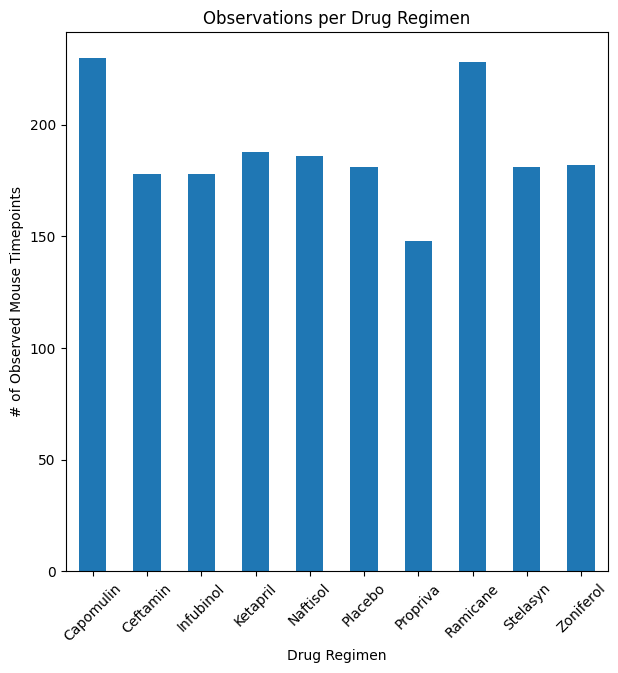

In [11]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using Pandas.
mouse_byDrug = clean_df.groupby('Drug Regimen')['Timepoint'].count()

mouse_byDrug.plot(kind = 'bar', figsize = (7, 7), rot = 45, 
                    title = 'Observations per Drug Regimen', 
                    ylabel = '# of Observed Mouse Timepoints')
plt.show()

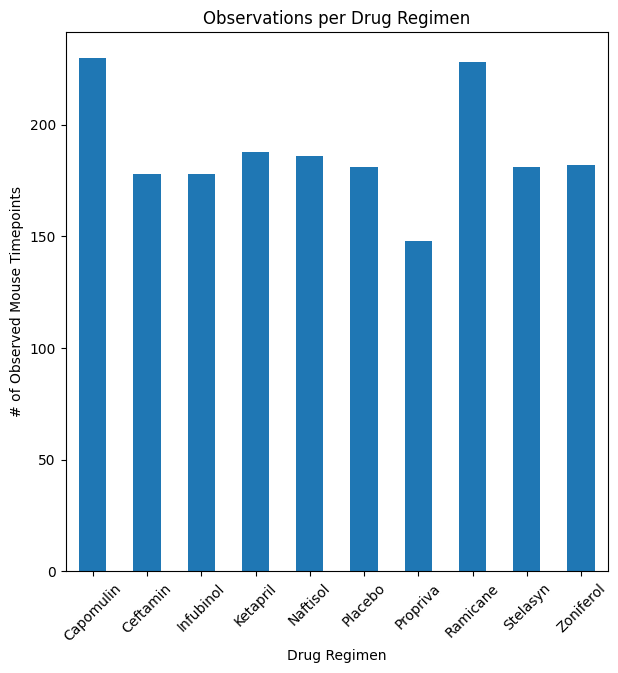

In [12]:
# Generate a bar plot showing the total number of rows (Mouse ID/Timepoints) for each drug regimen using pyplot.
xAxis = range(len(mouse_byDrug))
plt.figure(figsize = (7, 7))
plt.bar(xAxis, mouse_byDrug, align = 'center', width = 0.5)
plt.xticks(xAxis, mouse_byDrug.index, rotation = 45)
plt.xlim((xAxis[0] - 0.5), (xAxis[-1] + 0.5))
plt.xlabel('Drug Regimen')
plt.ylabel('# of Observed Mouse Timepoints')
plt.title('Observations per Drug Regimen')
plt.show()

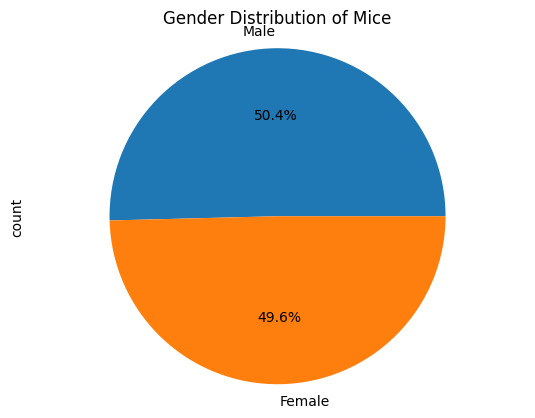

In [13]:
# Generate a pie chart, using Pandas, showing the distribution of unique female versus male mice used in the study
# Get the unique mice with their gender
mouse_byGender = clean_df.copy()
mouse_byGender = mouse_byGender.drop_duplicates('Mouse ID'
                                ).set_index('Mouse ID'
                                )['Sex']

# Make the pie chart
mouse_byGender.value_counts().plot(kind = 'pie', 
                                title = 'Gender Distribution of Mice', 
                                autopct = '%1.1f%%')
plt.axis('equal')
plt.show()

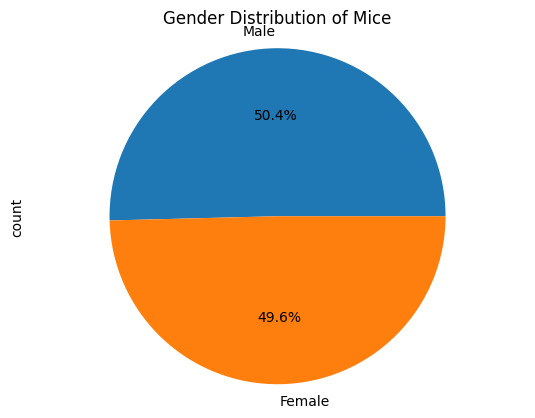

In [14]:
# Generate a pie chart, using pyplot, showing the distribution of unique female versus male mice used in the study

# Get the unique mice with their gender
# Using mouse_byGender again (Unique MouseID by Sex)

# Make the pie chart
plt.pie(mouse_byGender.value_counts(), 
        labels = mouse_byGender.value_counts().index, 
        autopct = '%1.1f%%')
plt.ylabel('count')
plt.title('Gender Distribution of Mice')
plt.axis('equal')
plt.show()

## Quartiles, Outliers and Boxplots

In [15]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse
timepoint_max = clean_df.groupby('Mouse ID')[['Timepoint']
                                            ].max().reset_index()

# Merge this group df with the original DataFrame to get the tumor volume at the last timepoint
tumor_df = pd.merge(clean_df, timepoint_max, how = 'inner', 
                    on = ['Mouse ID', 'Timepoint'])

In [16]:
# Put treatments into a list for a 'for' loop (and later for plot labels)
drugs = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
tumors = []

# Calculate the IQR and quantitatively determine if there are any potential outliers.
# Locate the rows which contain mice on each drug and get the tumor volumes
for drug in drugs:
    drug_select = tumor_df.loc[(tumor_df['Drug Regimen'] == drug), 'Tumor Volume (mm3)']
    quarts = drug_select.quantile([0.25, 0.5, 0.75])
    upperQ = quarts[0.75]
    lowerQ = quarts[0.25]

    iqr = upperQ - lowerQ
    upperLim = upperQ + (1.5 * iqr)
    lowerLim = lowerQ - (1.5 * iqr)

    # add subset
    tumors.append((drug_select.reset_index(drop = True)))

    # # Determine outliers using upper and lower bounds
    pot_outlier = drug_select.loc[((drug_select > upperLim) | (drug_select < lowerLim))]
    print(f"{drug}'s potential outliers: {pot_outlier}")

Capomulin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Ramicane's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)
Infubinol's potential outliers: 31    36.321346
Name: Tumor Volume (mm3), dtype: float64
Ceftamin's potential outliers: Series([], Name: Tumor Volume (mm3), dtype: float64)


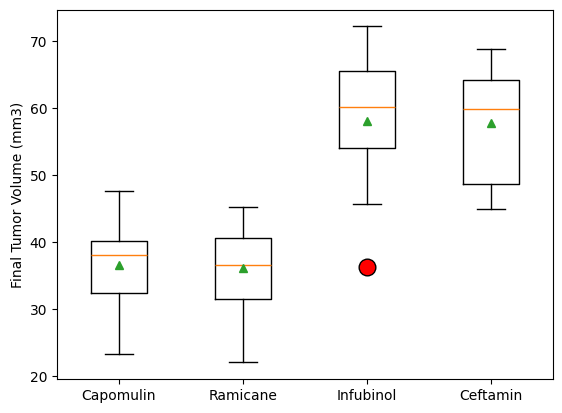

In [17]:
# Generate a box plot that shows the distribution of the tumor volume for each treatment group.
plt.boxplot(tumors, tick_labels = drugs, showmeans = True,
            flierprops = {
                'marker': 'o',
                'markerfacecolor': 'red',
                'markersize': 12
            })
plt.ylabel('Final Tumor Volume (mm3)')
plt.show()

## Line and Scatter Plots

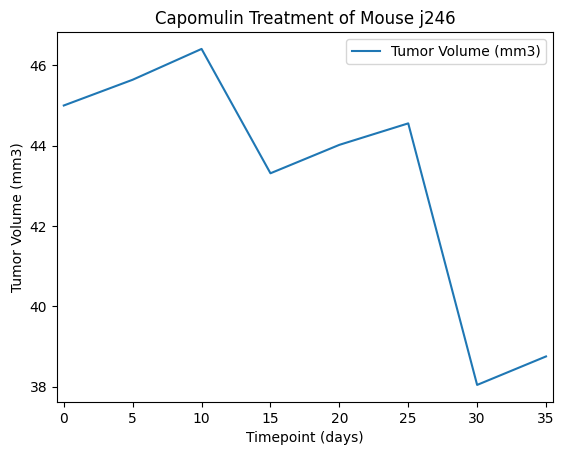

In [18]:
# Generate a line plot of tumor volume vs. time point for a single mouse treated with Capomulin
capomulin_select = clean_df.loc[clean_df['Drug Regimen'] == 'Capomulin', 
                                ['Mouse ID', 'Timepoint', 'Tumor Volume (mm3)', 'Weight (g)']]

# Randomly selecting a mouse treated with Capomulin with random.seed() and random.randint()
# Mouse is selected by Mouse ID for .loc[_bool] method
seed()
int_rand = randint(0, (len(capomulin_select['Mouse ID'].unique()) - 1))
mouse_rand = capomulin_select['Mouse ID'].unique()[int_rand]

# Retreiving relevant data of selected mouse and formatting DataFrame for charting
mouse_select = capomulin_select.loc[capomulin_select['Mouse ID'] == mouse_rand, 
                                    ['Timepoint', 'Tumor Volume (mm3)']
                                    ].set_index('Timepoint')

# Line chart of Tumor Volume vs Timepoint using DataFrame.plot() method
mouse_select.plot(kind = "line", xlabel = 'Timepoint (days)', 
                    ylabel = 'Tumor Volume (mm3)', 
                    title = f'Capomulin Treatment of Mouse {mouse_rand}',
                    xlim = ((mouse_select.index[0] - 0.5), (mouse_select.index[-1] + 0.5)))
plt.show()

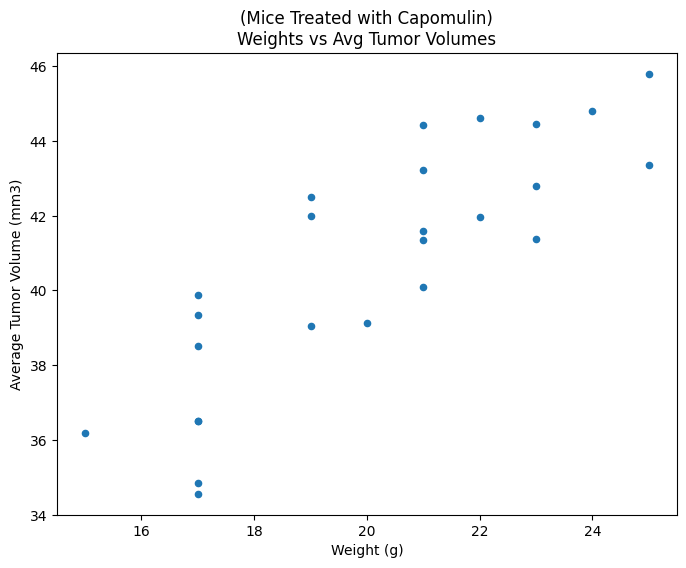

In [19]:
# Generate a scatter plot of mouse weight vs. the average observed tumor volume for the entire Capomulin regimen
# Mouse weight vs. same mouse's average observed tumor volume
tumor_byMouse = capomulin_select.groupby('Mouse ID')
mouse_weights = pd.DataFrame(tumor_byMouse['Weight (g)'].mean().astype(int))
tumor_avgs = pd.DataFrame(tumor_byMouse['Tumor Volume (mm3)'].mean())

scatter_df = pd.merge(mouse_weights, tumor_avgs, how = 'left', left_index = True, right_index = True)

scatter_df.plot(x = 'Weight (g)', y = 'Tumor Volume (mm3)', kind = 'scatter',
                figsize = (8, 6), ylabel = 'Average Tumor Volume (mm3)',
                title = '(Mice Treated with Capomulin)\nWeights vs Avg Tumor Volumes')
plt.show()

## Correlation and Regression

The correlation between the weight of a mouse and the average size of its tumor is 0.84


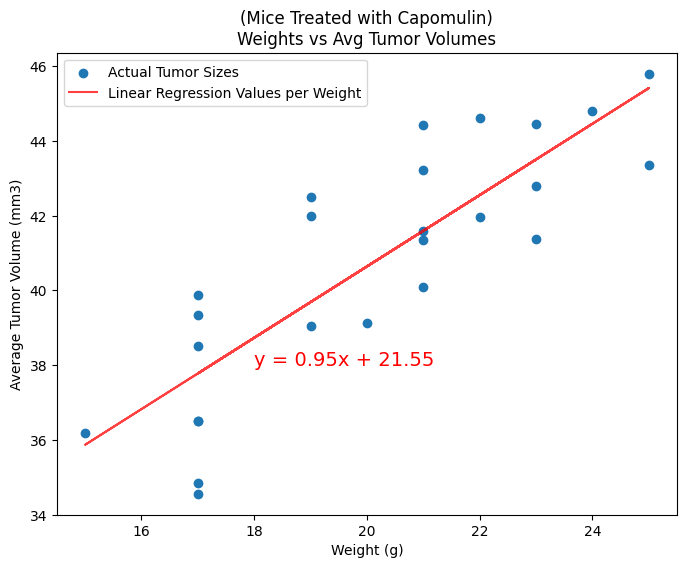

In [20]:
# Calculate the correlation coefficient and a linear regression model
# for mouse weight and average observed tumor volume for the entire Capomulin regimen
(x_slope, y_intercept, r_value, p_value, stdErr) = st.linregress(
                                            scatter_df['Weight (g)'], 
                                            scatter_df['Tumor Volume (mm3)'])
lineplot_df = scatter_df.copy()
lineplot_df[['Tumor Volume (mm3)']] = lineplot_df[['Weight (g)']] * x_slope + y_intercept  # Exp vals based on linear regress
lineplot_df = lineplot_df.set_index('Weight (g)')
str_eq = f'y = {round(x_slope, 2)}x + {round(y_intercept, 2)}'  # String for printed line equation

# Printing of regression value

print(f'The correlation between the weight of a mouse and the average size of its tumor is {round(r_value, 2)}')

# Plotting of scatter plot again but with linear regression analysis
# Plotting using return handles from plot functions for multiplots and formatting
fig, axis = plt.subplots(figsize = (8, 6))
ax_scatter = axis.scatter(x = scatter_df['Weight (g)'], 
                        y = scatter_df['Tumor Volume (mm3)'], 
                        label = 'Actual Tumor Sizes')
ax_line, = axis.plot(lineplot_df, color = 'red', alpha = 0.75, 
                    label = 'Linear Regression Values per Weight')
plt.xlabel('Weight (g)') 
plt.ylabel('Average Tumor Volume (mm3)')
plt.title('(Mice Treated with Capomulin)\nWeights vs Avg Tumor Volumes')
plt.annotate(str_eq, (18, 38), fontsize = 14, color = 'red')
axis.legend(loc = 'best')
plt.show()